In [23]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import sys

sys.path.append('..')

from algorithms.random_policy import RandomPolicy
from algorithms.sequence_models.decision_sequence_policy import DTPolicy
from algorithms.sequence_models.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.evaluate import evaluate_on_env
from data.door_key_dataset import DoorKeyDataset
from data.random_walk_dataset import RandomWalkDataset
from envs.door_key import DoorKeyEnv, DoorKeyEnvSmall
from data.trajectory import LimitedContextWrapper
from algorithms.sequence_models.config import TrainConfig
from algorithms.sequence_models.decision_transformer.trainer import TrainerDT
from envs.random_walk import RandomWalkEnv
from experiment import Experiment
import gymnasium as gym
from functools import partial
from algorithms.evaluate_policy import evaluate_policy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is ", device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
device is  cuda


In [12]:
from minigrid.wrappers import ImgObsWrapper

inner_env = gym.make('MiniGrid-DoorKey-5x5-v0')
inner_env_human = gym.make('MiniGrid-DoorKey-5x5-v0', render_mode='human')
env = ImgObsWrapper(inner_env)
env_human = ImgObsWrapper(inner_env_human)


config = TrainConfig(max_eval_ep_len=env.max_steps, context_len=32,
                     eval_model_interval=50)

#################### todo
# n_trajectories should be at least 10000 for the agent to learn I think 
####################
n_trajectories = 100
experiment_name = f"experiment_door_key_dataset_size={n_trajectories}"
if DoorKeyDataset.exists(experiment_name):
    traj_dataset = DoorKeyDataset.load(experiment_name)
else:
    traj_dataset = DoorKeyDataset(env, n_trajectories=n_trajectories, reward_scale=1)
    traj_dataset.save(experiment_name)

dt_model = DecisionTransformer(
    state_dim=traj_dataset.state_dim(),
    act_dim=traj_dataset.action_dim(),
    n_blocks=config.n_blocks,
    h_dim=config.embed_dim,
    context_len=config.context_len,
    n_heads=config.n_heads,
    drop_p=config.dropout_p,
).to(device)

make_dt_policy = partial(DTPolicy, model=dt_model, traj_dataset=traj_dataset, device=device, max_test_ep_len=config.max_eval_ep_len, context_length=config.context_len)

experiment = Experiment(
    model_name='dt',
    model=dt_model,
    env_name='MiniGrid-DoorKey-5x5-v0',
    env=env,
    experiment_name='generalization',
    traj_dataset=traj_dataset,
    dataset_name=f'size={len(traj_dataset)}',
    config=config,
    device=device,
    eval_policies_and_names=[
        (make_dt_policy(rtg=rtg), f'dt,rtg={rtg}')
        for rtg in np.linspace(0, 1.5, 10)
    ]
)

number of parameters 1159579


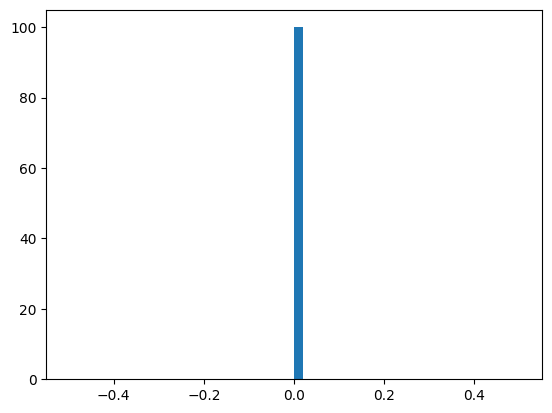

In [19]:
# rewards:
plt.hist([traj.rewards[0] for traj in traj_dataset], bins=50);

In [20]:
report = experiment.train_for(10)

training started


  0%|          | 0/10 [00:00<?, ?it/s]

time elapsed: 0:00:01
num of updates: 2100
loss: 0.11963
lr 0.00021
grad_norm 0.16742
time elapsed: 0:00:02
num of updates: 2200
loss: 0.11869
lr 0.00022
grad_norm 0.11477
time elapsed: 0:00:03
num of updates: 2300
loss: 0.11771
lr 0.00023
grad_norm 0.17040
time elapsed: 0:00:04
num of updates: 2400
loss: 0.11643
lr 0.00024
grad_norm 0.15080
time elapsed: 0:00:05
num of updates: 2500
loss: 0.11531
lr 0.00025
grad_norm 0.15091
time elapsed: 0:00:06
num of updates: 2600
loss: 0.11402
lr 0.00026
grad_norm 0.19151
time elapsed: 0:00:07
num of updates: 2700
loss: 0.11239
lr 0.00027
grad_norm 0.08055
time elapsed: 0:00:08
num of updates: 2800
loss: 0.11102
lr 0.00028
grad_norm 0.13913
time elapsed: 0:00:09
num of updates: 2900
loss: 0.10943
lr 0.00029
grad_norm 0.08722
time elapsed: 0:00:10
num of updates: 3000
loss: 0.10759
lr 0.00030
grad_norm 0.12973
saving current model at: /home/shayan/projects/RL-credit-assignment-experiment/logs/MiniGrid-DoorKey-5x5-v0/dt/generalization/generalization

<Axes: >

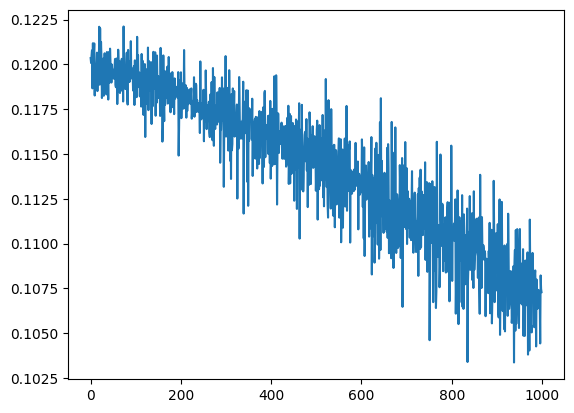

In [21]:
experiment.plot_loss(report)

In [28]:
# policy = RandomPolicy(env)
policy = make_dt_policy(rtg=1)

# you can also write another eval to store all the results not just the average
evaluate_policy(policy, env, num_eval_ep=2)

{'eval/avg_reward': 0.3848, 'eval/avg_ep_len': 157.0}

In [29]:
# wanna see what's happening? use env_human

# you can also write another eval to store all the results not just the average
evaluate_policy(policy, env_human, num_eval_ep=1)

KeyboardInterrupt: 